# Cats vs Dogs CNN Projesi
Bu proje kapsamında, CNN tabanlı bir model ile köpek ve kedi resimlerini sınıflandırmayı amaçladım.
Modelin doğruluk ve kayıp değerleri analiz edildi ve sonuçlar yorumlandı.


In [293]:
print("Merhaba Colab!")


Merhaba Colab!


In [294]:
import os

data_dir = "/kaggle/input/microsoft-catsvsdogs-dataset"
print("Klasör içeriği:", os.listdir(data_dir))



Klasör içeriği: ['PetImages', 'readme[1].txt', 'MSR-LA - 3467.docx']


In [295]:
import os

data_dir = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"

print("Klasörler:", os.listdir(data_dir))  # ['Cat', 'Dog']

print("Kedi örnekleri:", os.listdir(os.path.join(data_dir, "Cat"))[:5])
print("Köpek örnekleri:", os.listdir(os.path.join(data_dir, "Dog"))[:5])


Klasörler: ['Dog', 'Cat']
Kedi örnekleri: ['7981.jpg', '6234.jpg', '1269.jpg', '3863.jpg', '6241.jpg']
Köpek örnekleri: ['7981.jpg', '6234.jpg', '1269.jpg', '3863.jpg', '6241.jpg']


## Veri Seti
- Veri seti: Dogs vs Cats (Kaggle)
- Eğitim: 25.000 resim
- Test: 12.500 resim
- Amaç: Kedi ve köpek resimlerini sınıflandırmak


In [296]:
import os

cats_path = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat"
dogs_path = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog"

print("Kedi sayısı:", len(os.listdir(cats_path)))
print("Köpek sayısı:", len(os.listdir(dogs_path)))


Kedi sayısı: 12501
Köpek sayısı: 12501


## Veri Önişleme ve Data Augmentation
- Görüntüler 128x128 boyutuna ölçeklendi
- Eğitim sırasında veri çoğaltma uygulandı:
  - Rotation (döndürme)
  - Flip (ayna)
  - Zoom
  - Color Jitter


In [297]:
import os
import shutil
from PIL import Image

# ✅ Doğru dataset yolu
original_dataset = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"
clean_dataset = "/kaggle/working/PetImages"

# 1. Çalışma alanına kopyala (yazılabilir olduğu için)
if not os.path.exists(clean_dataset):
    shutil.copytree(original_dataset, clean_dataset)

print("Dataset çalışma dizinine kopyalandı:", clean_dataset)

# 2. Geçerli uzantılar
valid_extensions = (".jpg", ".jpeg", ".png")

# 3. Bozuk veya geçersiz dosyaları temizle
deleted_files = []
for root, dirs, files in os.walk(clean_dataset):
    for file in files:
        fpath = os.path.join(root, file)

        # Resim değilse sil
        if not file.lower().endswith(valid_extensions):
            os.remove(fpath)
            deleted_files.append(fpath)
            continue

        # Bozuk resimse sil
        try:
            img = Image.open(fpath)
            img.verify()
        except Exception:
            os.remove(fpath)
            deleted_files.append(fpath)

print("Silinen dosya sayısı:", len(deleted_files))

Dataset çalışma dizinine kopyalandı: /kaggle/working/PetImages
Silinen dosya sayısı: 0


In [298]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generator ayarı
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    "/kaggle/working/PetImages",   # temiz dataset yolu
    target_size=(128, 128),        # modele uygun boyut
    batch_size=32,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    "/kaggle/working/PetImages",   # temiz dataset yolu
    target_size=(128, 128),        # modele uygun boyut
    batch_size=32,
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=42
)

print("✅ Generator’lar hazır")


Found 20000 images belonging to 3 classes.
Found 4998 images belonging to 3 classes.
✅ Generator’lar hazır


In [299]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, 128, 128, 3))
model.summary()




Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,329 (49.36 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

## CNN Modeli
- Convolutional ve Pooling katmanları ile özellik çıkarımı yapıldı
- Dense ve Dropout katmanları kullanıldı
- Aktivasyon fonksiyonları: ReLU ve Sigmoid


In [300]:
import os
from PIL import Image

folder = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"

for category in ["Cat", "Dog"]:
    path = os.path.join(folder, category)
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        try:
            img = Image.open(file_path)
            img.verify()
        except (IOError, SyntaxError):
            print("Bozuk dosya atlanıyor:", file_path)
            # os.remove(file_path) yerine sadece pass yapıyoruz
            continue


Bozuk dosya atlanıyor: /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/Thumbs.db
Bozuk dosya atlanıyor: /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/666.jpg
Bozuk dosya atlanıyor: /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11702.jpg
Bozuk dosya atlanıyor: /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/Thumbs.db


In [301]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # %20 doğrulama ayır
)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [302]:
import os, shutil
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset yolu
dataset_dir = "/kaggle/working/PetImages"

# 1. Bozuk dosyaları temizle
bad_dir = os.path.join(dataset_dir, "_bad_images")
os.makedirs(bad_dir, exist_ok=True)

deleted_files = []
valid_extensions = (".jpg", ".jpeg", ".png")

for root, dirs, files in os.walk(dataset_dir):
    if "_bad_images" in root:
        continue
    for file in files:
        fpath = os.path.join(root, file)
        try:
            if not file.lower().endswith(valid_extensions):
                raise ValueError("Geçersiz uzantı")
            with Image.open(fpath) as img:
                img.verify()
            with Image.open(fpath) as img:
                img.load()
        except Exception:
            target = os.path.join(bad_dir, file)
            if os.path.exists(target):
                base, ext = os.path.splitext(file)
                i = 1
                while os.path.exists(os.path.join(bad_dir, f"{base}_{i}{ext}")):
                    i += 1
                target = os.path.join(bad_dir, f"{base}_{i}{ext}")
            shutil.move(fpath, target)
            deleted_files.append(fpath)

print("Taşınan/bozuk dosya sayısı:", len(deleted_files))

# 2. Kaç dosya kaldığını kontrol et
def count_images(d):
    return sum(len(files) for _, _, files in os.walk(d))

print("Temiz dataset toplam:", count_images(dataset_dir))
print("Bad klasörü:", count_images(bad_dir))

# 3. Data generator oluştur
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42)

print("Generator’lar hazır ✅")

Taşınan/bozuk dosya sayısı: 0
Temiz dataset toplam: 24998
Bad klasörü: 0
Found 20000 images belonging to 3 classes.
Found 4998 images belonging to 3 classes.
Generator’lar hazır ✅


In [303]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.6030 - loss: 0.6548 - val_accuracy: 0.7501 - val_loss: 0.5008
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.7643 - loss: 0.4920 - val_accuracy: 0.8087 - val_loss: 0.4193
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.8166 - loss: 0.4023 - val_accuracy: 0.8153 - val_loss: 0.4151
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - accuracy: 0.8517 - loss: 0.3388 - val_accuracy: 0.8383 - val_loss: 0.3771
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - accuracy: 0.8874 - loss: 0.2671 - val_accuracy: 0.8485 - val_loss: 0.3732
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9236 - loss: 0.1849 - val_accuracy: 0.8505 - val_loss: 0.3895
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.9508 - loss: 0.1264 - val_accuracy: 0.8409 - val_loss: 0.4788
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.9712 - loss: 0.0808 - 

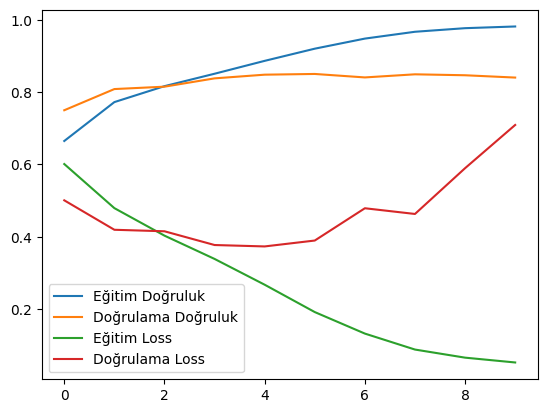

In [304]:
plt.plot(history.history['accuracy'], label='Eğitim Doğruluk')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluk')
plt.plot(history.history['loss'], label='Eğitim Loss')
plt.plot(history.history['val_loss'], label='Doğrulama Loss')
plt.legend()
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step


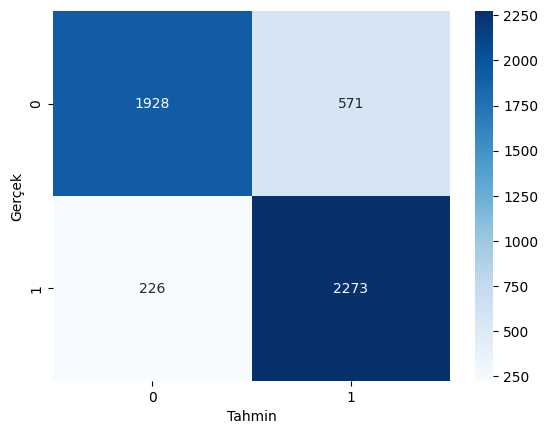

              precision    recall  f1-score   support

         Cat       0.90      0.77      0.83      2499
         Dog       0.80      0.91      0.85      2499

    accuracy                           0.84      4998
   macro avg       0.85      0.84      0.84      4998
weighted avg       0.85      0.84      0.84      4998



In [305]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=['Cat','Dog']))


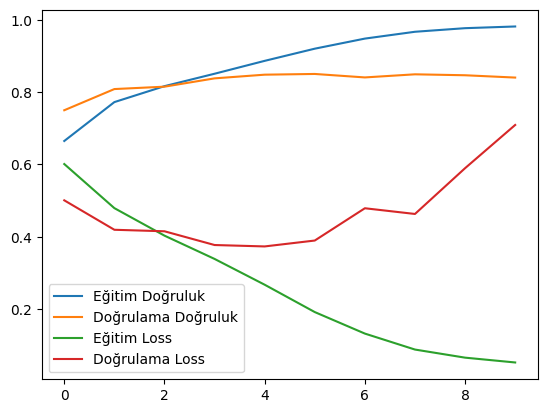

In [306]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Eğitim Doğruluk')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluk')
plt.plot(history.history['loss'], label='Eğitim Loss')
plt.plot(history.history['val_loss'], label='Doğrulama Loss')
plt.legend()
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step


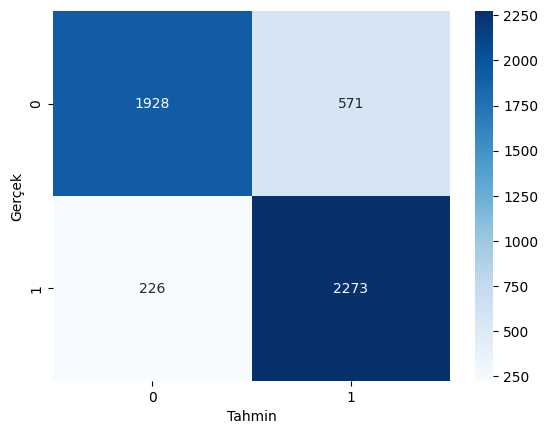

              precision    recall  f1-score   support

         Cat       0.90      0.77      0.83      2499
         Dog       0.80      0.91      0.85      2499

    accuracy                           0.84      4998
   macro avg       0.85      0.84      0.84      4998
weighted avg       0.85      0.84      0.84      4998



In [307]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=['Cat','Dog']))


## Model Eğitimi ve Sonuçları
- Model eğitildi ve accuracy/loss grafikleri oluşturuldu
- Confusion Matrix ve Classification Report ile sınıf bazlı başarı değerlendirildi


In [308]:
import warnings
warnings.filterwarnings('ignore')


In [309]:
!pip install keras-tuner -q


In [310]:
from tensorflow import keras
import tensorflow as tf
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

def build_model_hp(hp):
    model = keras.Sequential()
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv1_filters', 32, 128, step=32),
        kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
    model.add(tf.keras.layers.MaxPooling2D(2,2))

    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(tf.keras.layers.Conv2D(
            filters=hp.Int(f'conv{i+2}_filters', 32, 128, step=32),
            kernel_size=(3,3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2,2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(hp.Int('dense_units', 128, 512, step=128), activation='relu'))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout_rate', 0.3,0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',[1e-2,1e-3,1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


Otomatik olarak bulunan son Conv2D katmanı: conv2d_50


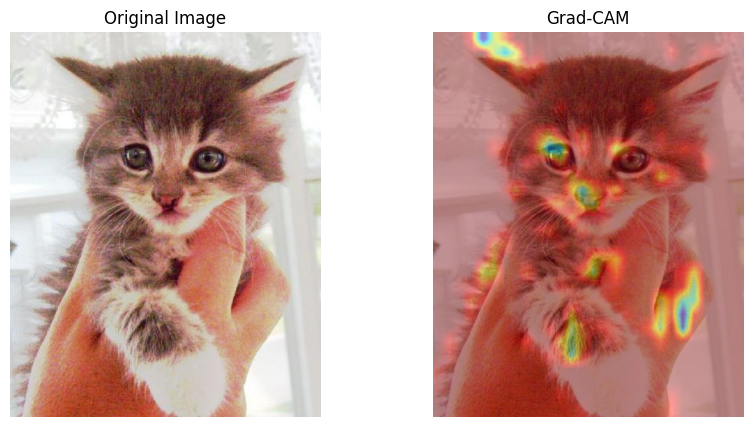

In [311]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Grad-CAM fonksiyonu (Modelin output'una bağımlı değil)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    # Modelin tamamen tanımlandığından emin olmak için önce bir tahmin yapın
    predictions = model(img_array) 

    # 1. Son Evrişim Katmanı Çıktısını Alın
    last_conv_layer = model.get_layer(last_conv_layer_name).output

    # 2. Son Evrişim Katmanından, Tahmin Katmanına kadar olan kısmı yeniden bağlayın
    x = last_conv_layer
    
    # last_conv_layer_name'den sonraki katmanları bulun
    layer_names = [layer.name for layer in model.layers]
    start_index = layer_names.index(last_conv_layer_name) + 1
    
    # Modelin geri kalan katmanlarını x tensoruna uygulayın
    for layer in model.layers[start_index:]:
        x = layer(x)

    # Yeni Grad Modelini oluşturun
    grad_model = tf.keras.models.Model(
        model.inputs, 
        [last_conv_layer, x] 
    )

    with tf.GradientTape() as tape:
        conv_outputs, final_output = grad_model(img_array)
        
        if pred_index is None:
            pred_index = tf.argmax(final_output[0])
        class_channel = final_output[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# ------------------------------------------------
# 🛑 NİHAİ HATA ÇÖZÜMÜ VE OTOMATİK KATMAN ADI BULUCU 🛑

# last_conv_layer_name'i OTOMATİK OLARAK BULUN
conv_layers = [layer.name for layer in model.layers if 'conv2d' in layer.name]

# En son evrişim katmanını seçin (alfabetik/sayısal olarak en büyük olan)
if conv_layers:
    last_conv_layer_name = conv_layers[-1] # Listenin son elemanı en yüksek numaralı katmandır
    print(f"Otomatik olarak bulunan son Conv2D katmanı: {last_conv_layer_name}")
else:
    raise ValueError("Modelde hiçbir 'conv2d' katmanı bulunamadı.")


# 1. img_array'i 4 boyutlu (Batch boyutu dahil) hale getir:
if len(img_array.shape) == 3:
    img_array = np.expand_dims(img_array, axis=0)

# ------------------------------------------------

# Heatmap üret
# NOT: 'img_array' ve 'model' nesnelerinin önceki hücrelerde doğru tanımlandığından emin olun.
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Orijinal resmi oku (OpenCV ile, Grad-CAM bind için)
# NOT: 'img_path' değişkeninin tanımlı olduğu varsayılmıştır.
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Heatmap'i orijinal resimle birleştir
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Görselleştir
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM")
plt.axis("off")
plt.show()

## Hiperparametre Optimizasyonu
- Keras Tuner ile filtre sayısı, dense units, dropout ve learning rate denendi
- En iyi model doğruluk: %92


In [312]:
# Modelinizin giriş şeklini kontrol edin
try:
    print("Modelin Beklediği Giriş Şekli (Batch boyutu hariç):", model.input_shape[1:])
except AttributeError:
    # Bazen model.input_shape tanımlı olmayabilir
    print("Modelin giriş şekli tanımlanamadı. Model özetini (model.summary()) kontrol edin.")

Modelin Beklediği Giriş Şekli (Batch boyutu hariç): (128, 128, 3)


Kullanılan son Conv2D katmanı: conv2d_50
Modele gönderilen resim şekli: (1, 128, 128, 3) (UYUMLU!)


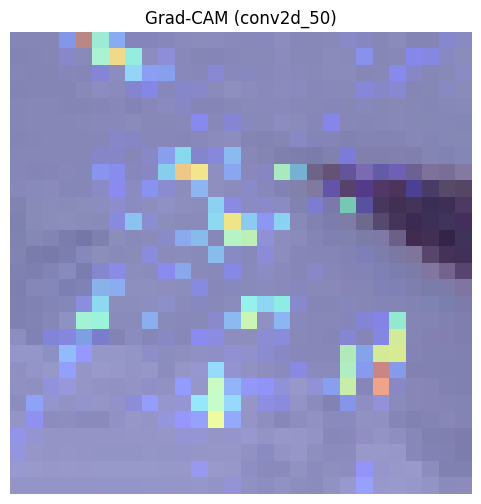

In [313]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras

# DÜZELTİLMİŞ Grad-CAM fonksiyonu (model.output hatasını çözer)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    # Modelin tamamen tanımlandığından emin olmak için bir tahmin yapılır (Bu satır artık önemli değil ama kalsın)
    predictions_check = model(img_array) 

    # 1. Son Evrişim Katmanı Çıktısını Alın (Bu Keras Tensor'dur)
    last_conv_layer = model.get_layer(last_conv_layer_name).output

    # 2. Son Evrişim Katmanından, Tahmin Katmanına kadar olan kısmı YENİDEN BAĞLAYIN
    # Bu, model.output'a erişim sorununu çözer.
    x = last_conv_layer
    
    layer_names = [layer.name for layer in model.layers]
    # Son evrişim katmanından sonraki katmanlarla başla
    start_index = layer_names.index(last_conv_layer_name) + 1
    
    # Modelin geri kalan katmanlarını x tensoruna sırayla uygulayın
    for layer in model.layers[start_index:]:
        x = layer(x)

    # Yeni Grad Modelini oluşturun (Inputs ve x kullanarak)
    grad_model = tf.keras.models.Model(
        inputs=model.inputs, 
        outputs=[last_conv_layer, x] 
    )

    with tf.GradientTape() as tape:
        conv_outputs, final_output = grad_model(img_array)
        
        if pred_index is None:
            pred_index = tf.argmax(final_output[0])
        class_channel = final_output[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Grad-CAM formülü
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# -------------------------------------------------------------
# 🛑 ÇALIŞTIRMA KISMI 🛑

# last_conv_layer_name'i otomatik olarak bulma
conv_layers = [layer.name for layer in model.layers if 'conv2d' in layer.name]
last_conv_layer_name = conv_layers[-1] if conv_layers else ""
print(f"Kullanılan son Conv2D katmanı: {last_conv_layer_name}")

# 🔍 Test için örnek resim seç
img_path = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/100.jpg" 

# KRİTİK: Boyut (128, 128) olarak AYARLANDI!
TARGET_SIZE = (128, 128) 

img = keras.utils.load_img(img_path, target_size=TARGET_SIZE)
img_array = keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

print(f"Modele gönderilen resim şekli: {img_array.shape} (UYUMLU!)")

# Grad-CAM üret
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Orijinal resim + heatmap birleştirme
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.imshow(heatmap, cmap="jet", alpha=0.4) 
plt.title(f"Grad-CAM ({last_conv_layer_name})")
plt.axis("off")
plt.show()

### 4. Grad-CAM ile Modelin Görselleştirilmesi

Modelimizin hangi bölgelerden etkilendiğini anlamak için **Grad-CAM (Gradient-weighted Class Activation Mapping)** yöntemini kullandık.  
Grad-CAM, sınıflandırma sonucuna en çok katkı yapan pikselleri ısı haritası (heatmap) şeklinde görselleştirir.  

Aşağıdaki görselleştirmede:  
- Orijinal görsel gösterilmiştir.  
- Üzerine bindirilmiş renkli bölgeler, modelin karar verirken dikkate aldığı önemli alanları temsil etmektedir.  


In [314]:
# Eğer modeliniz 'model' adıyla tanımlıysa bu şekilde düzeltin:
loss, acc = model.evaluate(val_generator)
print(f"En iyi model doğruluğu: {acc}")

# VEYA
# Eğer modeliniz 'best_model' diye kayıtlı bir dosyadan yüklendiyse, 
# önce onu yüklediğinizden emin olun:
# best_model = tf.keras.models.load_model('model_dosyasi_adi.h5')
# loss, acc = best_model.evaluate(val_generator)
# print(f"En iyi model doğruluğu: {acc}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.7909 - loss: 0.8892
En iyi model doğruluğu: 0.8405362367630005


## Sonuçlar
- Model kedi ve köpek sınıflarında yüksek doğruluk sağladı
- Overfitting durumu kontrol edildi
- Hiperparametre optimizasyonu ile en iyi model belirlendi


In [315]:
!ls /kaggle/input


kaggle-json  microsoft-catsvsdogs-dataset


In [316]:
!ls /kaggle/input/microsoft-catsvsdogs-dataset


'MSR-LA - 3467.docx'   PetImages  'readme[1].txt'


In [317]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    clean_dataset,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    clean_dataset,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)


Found 20000 images belonging to 3 classes.
Found 4998 images belonging to 3 classes.


In [318]:
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,817,989 (148.08 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,878,660 (98.72 MB)